# Basic Model Interface (BMI) for streamflow prediction using Long Short-Term Memory (LSTM) networks
This Long Short-Term Memory (LSTM) network was developed for use in the [Next Generation National Water Model (Nextgen)](https://github.com/NOAA-OWP/ngen). Nextgen runs models with [Basic Model Interface (BMI)](https://bmi.readthedocs.io/en/latest/).

### These libraries should all be available in the environment.yml through the command
`conda activate bmi_lstm`
#### Make sure that the library is installed
`pip install lstm`

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from netCDF4 import Dataset
from lstm import bmi_lstm  # Load module bmi_lstm (bmi_lstm.py) from lstm package.
import pickle
import xarray as xr

### Set path to the project/repo folder for the LSTM model

When the LSTM Python model is used within NextGen, this folder will be in the "ngen" folder at: ngen/extern/lstm_py, and the LSTM Python package will be at: ngen/extern/{repo_name}/{package_name}.  Note that paths to required datasets will be relative to this project folder.

You will need to set your full local path `lstm_dir` to directory where you cloned the repo


In [2]:
import sys
import os, os.path
lstm_dir = os.path.expanduser('../lstm/')
os.chdir( lstm_dir )
import pandas as pd

### This sample dataset comes from NeuralHydrology: 
These are just samples. These models can run with any forcing data. This is just a sample that is used for examples within NeuralHydrology.
https://github.com/neuralhydrology/neuralhydrology/tree/master/test/test_data/camels_us/hourly
* 02064000 Falling River nr Naruna, VA
* 01547700 Marsh Creek at Blanchard, PA
* 03015500 Brokenstraw Creek at Youngsville, PA
* 01022500 Narraguagus River at Cherryfield, Maine

In [3]:
sample_data = Dataset('../data/usgs-streamflow-nldas_hourly.nc', 'r')
sample_basins = {sample_data['basin'][x]:x for x in range(len(list(sample_data['basin'])))}

In [4]:
basin_id = "01022500" # Chose from: ["01022500", "03015500", "01547700", "02064000"] 

In [5]:
# Create an instance of the LSTM model with BMI
model_instance = bmi_lstm.bmi_LSTM()

# Initialize the model with a configuration file
model_instance.initialize(bmi_cfg_file=Path(f'../bmi_config_files/{basin_id}_nh_NLDAS_hourly.yml'))

Will not print anything except errors because verbosity set to 0
self.verbose 0


/Users/jmframe/miniconda3/envs/bmi_lstm/lib/python3.10/site-packages/lstm/bmi_lstm.py:268: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_state_dict = torch.load(trai

# Test the model BMI implimentation

Forcing data info:
  n_precip = 26304
  n_temp   = 26304
  precip_data.dtype = float32
  temp_data.dtype   = float32
  precip:  min, max = 0.0 , 18.51529
  temp:    min, max = 245.45935 , 305.75153

Working, please wait...


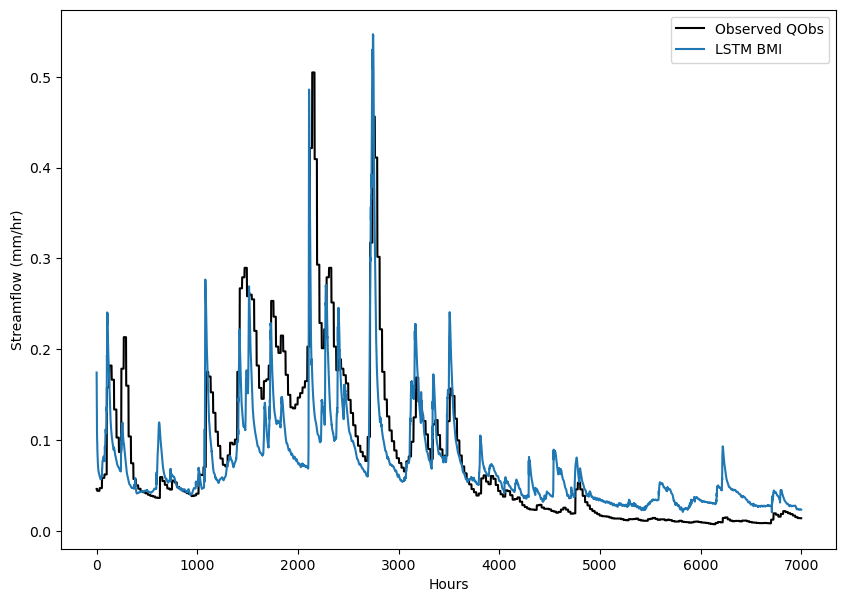

NSE: 0.58


In [6]:
# Get the index of the basin
basin_index = np.where(sample_data["basin"][:] == basin_id)[0][0]  # Extracts the correct index

# Get sample data time series for precip and temp
precip_data = sample_data['total_precipitation'][basin_index, :].data  # Index by both dimensions
temp_data   = sample_data['temperature'][basin_index, :].data + 273.15  # Index by both dimensions
n_precip    = precip_data.size

print('Forcing data info:')
print('  n_precip =', n_precip)
print('  n_temp   =', temp_data.size)
print('  precip_data.dtype =', precip_data.dtype)
print('  temp_data.dtype   =', temp_data.dtype)
print('  precip:  min, max =', precip_data.min(), ',', precip_data.max() )
print('  temp:    min, max =', temp_data.min(), ',', temp_data.max() )
print()

# Store output values in an array, so we can plot it afterwards (faster)
runoff_output_ = np.zeros( n_precip )

k = 0
VERBOSE = False
print('Working, please wait...')
for k in range( n_precip ):
    precip = precip_data[k]
    temp   = temp_data[k]
    if (VERBOSE):
        print('k, precip, temp =', k, ',', precip, ',', temp)

    # Set the model forcings to those in the sample data

    model_instance.set_value('atmosphere_water__liquid_equivalent_precipitation_rate', precip)
    model_instance.set_value('land_surface_air__temperature',temp)

    # Updating the model calculates the runoff from the inputs and the model state at this time step
    model_instance.update()

    # Add the output to a list so we can plot
    dest_array = np.zeros(1)

    model_instance.get_value('land_surface_water__runoff_depth', dest_array)
    runoff_ = dest_array[0]
    # print('val =', runoff_limited)
    
    #------------------------------------------------
    # Make output unit consistant with CAMELS mm/hr
    #------------------------------------------------
    runoff_ *= 1000   # (correct factor is 1000)
    runoff_output_[ k ] = runoff_

    
# Define the start and end for plotting
start_plot = 0
end_plot   = 7000

plt.figure(figsize=(10, 7))

# Extract observed discharge (qobs) for the correct basin and date range
obs_qobs = sample_data['qobs_CAMELS_mm_per_hour'][basin_index, start_plot:end_plot].data

# Plot observed data
plt.plot(obs_qobs, label='Observed QObs', color='k')

# Plot model predictions
plt.plot(runoff_output_[start_plot:end_plot], label='LSTM BMI')

# Labels and legend
plt.ylabel('Streamflow (mm/hr)')
plt.xlabel('Hours')
plt.legend()
plt.show()

# Calculate a metric
obs = np.array(sample_data['qobs_CAMELS_mm_per_hour'][basin_index])
sim = runoff_output_
### sim = np.array(runoff_output_list_limited)
denominator = ((obs - obs.mean())**2).sum()
numerator = ((sim - obs)**2).sum()
value = 1 - numerator / denominator
print("NSE: {:.2f}".format(1 - numerator / denominator))